In [1]:
import pandas as pd
import seaborn as sns
import numpy as np 
from src.utils import heatmap_builder


In [4]:
import requests
file_id = "1G3XloBr9JAcIhyxQL7WrH7tHlSHBNNiv&export=download"
URL = "https://drive.google.com/uc?id=" + file_id
response = requests.get(URL, stream=True)
with open("../../data/IBRD_Statement_Of_Loans.csv", "wb") as output_file:
    for chunk in response.iter_content(chunk_size=32768):
        if chunk:
            output_file.write(chunk)

# Глава 1 - Предобработка данных
## Глава 1.1 - Загрузка и предварительный анализ данных

In [2]:
data = pd.read_csv("https://drive.google.com/file/d/1G3XloBr9JAcIhyxQL7WrH7tHlSHBNNiv/view?usp=sharing", low_memory=True)
old_data = data[:]

/tmp/ipykernel_5672/2084058070.py:1: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../../data/IBRD_Statement_Of_Loans.csv", low_memory=True)


Построим тепловую карту пропущенных значений

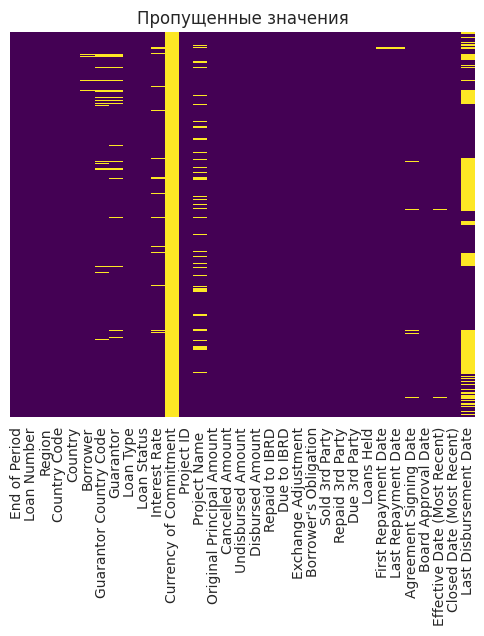

In [3]:
heatmap_builder(old_data.isnull(),figsize=(6, 5), title="Пропущенные значения", save_path="../../output/graphics/heatmaps/NaN_values_heatmap.png", xticklabels=data.columns)

Оценим размерность датасета

In [4]:
print("Размерность датасета: ", data.shape)

Размерность датасета:  (1259887, 33)


### Глава 1.2 - Очистка данных от дубликатов

Достаточно много строк. Среди них, вероятно, есть дубликаты. Проверим данные на их наличие

In [5]:
print("Количество дубликатов в датасете: ", data.duplicated().sum())
data.drop_duplicates(inplace=True)

Количество дубликатов в датасете:  56


### Глава 1.3 - Очистка данных от пропущенных значений

Первый столбец, который привлекает наше внимание - это "Currency of Commitment". На данный момент в нем отсутствует 100% значений. Этот столбец предназначен для хранения информации о валюте, в которой деноминирован заем, аккредитив, грант или трастовый фонд.

Однако в текущем наборе данных отсутствуют конкретные значения в этом столбце. Более того, поскольку этот столбец слабо взаимодействует с другими, мы можем безболезненно удалить его из набора данных. В случае необходимости в будущем, например, для проведения расчетов, мы всегда можем восстановить или заполнить значениями, предоставленными заказчиком.

Таким образом, принято решение удалить столбец "Currency of Commitment" из текущего набора данных. Это не повлияет на целостность информации, а упростит дальнейший анализ данных.

In [6]:
data = data.drop("Currency of Commitment", axis=1)

Далее обратим внимание на столбец Project Name, в котором, если оценивать визуально, пропущено достаточно много значений.
Посмотрим сколько процентов значений пропущено в данном столбце.

In [7]:
print("Процент пропущенных значений в столбце Project Name: ", round(data["Project Name "].isnull().sum()/len(data["Project Name "])*100, 2), "%")
data.rename(columns={col:col.strip() for col in data.columns}, inplace=True)

Процент пропущенных значений в столбце Project Name:  12.63 %


_Также в ходе работы со столбцом Project Name было обнаружено, что в названии содержится пробел в конце, что может вызывать трудности при поиске значений. Удалим возможные пробелы в конце названий всех колонок, чтобы ни я, ни другие люди не сталкивались впредь с этой проблемой._

12.6% пропущенных значений - большое количество, поэтому мы не можем просто удалить строки с пропущенными значениями, так как это может сильно повлиять на результаты анализа. Поэтому мы заполним пропущенные значения в столбце Project Name значением "Unknown" и будем рассматривать их как отдельный класс значений.

In [8]:
data["Project Name"].fillna("Unknown project", inplace=True)

### Работа с пропущенными значениями в столбцах "Guarantor Country Code" и "Guarantor"

Далее мы обратим внимание на столбцы "Guarantor Country Code" и "Guarantor". График показывает, что в этих столбцах существенное количество пропущенных значений. Однако, поскольку эти столбцы взаимосвязаны, мы можем воспользоваться заполнением пропущенных значений в одном столбце значениями из другого.

Давайте оценим количество пропущенных значений, которые мы можем восстановить. Для этого выделим строки, в которых пропущено значение в одном из столбцов, но не в другом.

| Guarantor Country Code | Guarantor |
|------------------------|-----------|
|          NaN           |    Value  |
|        Value           |     NaN   |

Таким образом, мы сможем восстановить значения в одном столбце, используя информацию из другого. Этот процесс поможет уменьшить количество пропущенных данных и сделает нашу таблицу более информативной.


In [9]:
data[
    (data["Guarantor Country Code"].isna() & data["Guarantor"].notna()) | 
    ((data["Guarantor Country Code"].notna() & data["Guarantor"].isna()))
][["Guarantor", "Guarantor Country Code"]]

,Guarantor,Guarantor Country Code
6935,Namibia,NaN
7073,Namibia,NaN
15835,Namibia,NaN
15974,Namibia,NaN
24745,Namibia,NaN
...,...,...
1239754,Namibia,NaN
1248664,Namibia,NaN
1248802,Namibia,NaN
1257724,Namibia,NaN


Отлично, в худшем случае 34,5к строк можно восстановить (в конце окажется, что можно восстановить все!!!). Построим график пропущенных значений для последующего сравнения:

In [10]:
heatmap_builder(data[["Guarantor","Guarantor Country Code"]].isnull(),figsize=(2, 5), title="Пропущенные значения до восстановления", save_path="../../output/graphics/heatmaps/NaN_values_heatmap_before_guarantor_fix.png", xticklabels=["Guarantor","Guarantor Country Code"], show=False)

In [11]:
before = data["Guarantor Country Code"].isna().sum()
print("Количество пропущенных значений в столбце Guarantor Country Code до восстановления: ", before)

Количество пропущенных значений в столбце Guarantor Country Code до восстановления:  47075


### Проверка совпадения значений в столбцах "Country" и "Guarantor"

Если логически рассматривать, то столбец "Country" содержит информацию о стране, организации внутри которой был дан заем, в то время как столбец "Guarantor" указывает на страну-гаранта. Теоретически, эти страны не обязательно должны совпадать. Однако, возможно, на практике они часто совпадают.

Давайте проведем анализ, чтобы проверить эту гипотезу, и определим процент совпадающих значений для обоих столбцов:


In [12]:
same_data = np.sum(data['Country'].values == data['Guarantor'].values)
total_data = data['Country'].count()
print("Количество строк, в которых значения в столбцах Country и Guarantor совпадают: ", same_data)
print("Процент строк, в которых значения в столбцах Country и Guarantor совпадают: ", round(same_data/total_data*100, 2), "%")
print("Процент строк, в которых значение в столбцах Guarantor NaN: ", round(data["Guarantor"].isna().sum()/total_data*100, 2), "%")

Количество строк, в которых значения в столбцах Country и Guarantor совпадают:  1178782
Процент строк, в которых значения в столбцах Country и Guarantor совпадают:  93.57 %
Процент строк, в которых значение в столбцах Guarantor NaN:  5.83 %


Также можно было провести тест Левенштейна для определения схожести строк, но это было бы слишком долго. Поэтому я решил ограничиться простым сравнением строк. В данном случае этого достаточно.

### Предсказание пропущенных значений в столбцах "Guarantor Country Code" и "Guarantor" с использованием "Country"

На построенном выше графике пропущенных значений мы можем заметить, что столбец "Country" не содержит пропусков. Процент совпадения значений между "Country" и "Guarantor" составляет 93%.

Учитывая высокий процент совпадения значений, мы можем предсказать пропущенные значения в столбцах "Guarantor Country Code" и "Guarantor", используя столбец "Country".

Давайте создадим ассоциативную таблицу стран и их кодов для удобства работы с данными. Для этого воспользуемся столбцами "Country" и "Country Code", где значения в каждой строке соответствуют друг другу. Мы можем проверить соответствие:


In [13]:
data["Country"] = data["Country"].apply(lambda x: x.strip())
countries = pd.Series(data["Country"].unique(), name="Country")
country_codes = pd.Series(data["Country Code"].unique(), name="Country Code")
country_code_table = pd.concat([countries.reset_index(drop=True), country_codes.reset_index(drop=True)], axis=1)
country_code_table

,Country,Country Code
0,France,FR
1,Netherlands,NL
2,Denmark,DK
3,Luxembourg,LU
4,Chile,CL
...,...,...
151,Cape Verde,NaN
152,Eastern Africa,NaN
153,Western Africa,NaN
154,Czechia,NaN


Однако стоит заметить, что в полученной таблице есть страны, которым не соответствует код и эту проблему также нужно решить:

In [14]:
country_code_table[country_code_table["Country Code"].isna()]

,Country,Country Code
137,Namibia,NaN
147,Swaziland,NaN
148,Turkey,NaN
149,"Macedonia, former Yugoslav Republic of",NaN
150,"Macedonia, former Yugoslav Republic",NaN
151,Cape Verde,NaN
152,Eastern Africa,NaN
153,Western Africa,NaN
154,Czechia,NaN
155,Viet Nam,NaN


Проведу дополнительную очистку данных

In [15]:
countries = pd.Series(data["Country"].unique(), name="Country")
country_code_table = pd.concat([countries, country_codes], axis=1)
bad_countries = country_code_table[country_code_table["Country Code"].isna()]

### Обработка неоднозначных названий стран

При анализе данных обнаружены неоднозначности в названиях стран. Например, "Macedonia, former Yugoslav Republic of" и "North Macedonia" на самом деле представляют одну и ту же страну.

Также возможны другие варианты названий для одной и той же страны. Для унификации данных, присвоим одинаковые коды тем странам, которые фактически являются одной и той же.

Давайте проведем изменения как в столбце "Country", так и в столбце "Guarantor":

In [16]:
keywords = ['Turk', 'Macedonia', 'Cape', 'Eastern', 'Western', 'Cze', 'Viet']

    
data['Country'] = data['Country'].replace()
    
replaceable_countries = ['Namibia', 'Turkiye', 'Macedonia, former Yugoslav Republic of', 'Macedonia, former Yugoslav Republic', 'Czechia', 'Viet Nam', 'Eastern Africa', 'Western Africa', 'Cape Verde', 'Swaziland']

countries_for_replace = ['Namibia', 'Turkey', 'North Macedonia', 'North Macedonia', 'Czech Republic', 'Vietnam', 'Eastern Africa', 'Western Africa', 'Cape Verde', 'Eswatini']

replace_dict = dict(zip(replaceable_countries, countries_for_replace))
data['Country'] = data['Country'].replace(replace_dict)

countries = pd.Series(data["Country"].unique(), name="Country")
country_codes = pd.Series(data["Country Code"].unique(), name="Country Code")
country_code_table = pd.concat([countries, country_codes], axis=1)
country_code_table[country_code_table["Country Code"].isna()]
country_code_table[country_code_table.isna().any(axis=1)]

/tmp/ipykernel_5672/684308917.py:4: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  data['Country'] = data['Country'].replace()


,Country,Country Code
137,Namibia,NaN
147,Cape Verde,NaN
148,Eastern Africa,NaN
149,Western Africa,NaN


Заполним NaN ячейки в столбце Guarant для дальнейших операций с этим столбцом. Как мы до этого выяснили, 93.57% значений столбцов Country и Guarant совпадают, ещё 5.83% значений являются NaN. Именно эти пустые значения мы и заполним.

Также проверим все значения в столбце Guarantor, которые не совпадают со значениями в столбце Country. Возможно, это какие-то регионы или другие страны, которые никогда не брали займ, а только выступали в качестве гаранта.

In [17]:
data["Guarantor"].fillna(data["Country"], inplace=True)
data[~data["Guarantor"].isin(data["Country"])]["Guarantor"].unique()

array(['Turkiye', 'United Kingdom', 'Swaziland',
       'Macedonia, former Yugoslav Republic of',
       'Macedonia, former Yugoslav Republic', 'Czechia', 'Viet Nam'],
      dtype=object)

Мы обнаружили несовпадающие значения. Все, кроме United Kingdom встречались нам ранее и были переименованы заранее в Country. Переименуем их и в Guarant, а также учтём United Kingdom в будущем при составлении словаря стран и их кодов.

Добавим коды для стран и регионов, которые не были найдены в таблице. Также есть вероятность, что в столбце Guarantor всё ещё есть значения, которые не содержатся в столбце Country. Проверим это:

In [18]:
country_code_table.loc[country_code_table["Country"] == "Namibia", "Country Code"] = "NA"
country_code_table.loc[country_code_table["Country"] == "Western Africa", "Country Code"] = "WA"
country_code_table.loc[country_code_table["Country"] == "Eastern Africa", "Country Code"] = "EA"
country_code_table.loc[country_code_table["Country"] == "Cape Verde", "Country Code"] = "CV"


replace_dict = dict(zip(replaceable_countries, countries_for_replace))
data['Guarantor'] = data['Guarantor'].replace(replace_dict)

data[~data["Guarantor"].isin(data["Country"])]["Guarantor"].unique()

array(['United Kingdom'], dtype=object)

Из таблицы сделаем словарь, где ключом будет название страны, а значением - код страны. Это позволит нам быстрее получать код страны по названию, нежели из таблицы. Не забываем про United Kingdom, упомянутую ранее.

In [19]:
country_dict = dict(zip(country_code_table["Country"], country_code_table["Country Code"]))
country_dict["United Kingdom"] = "GB"
country_dict

{'France': 'FR',
 'Netherlands': 'NL',
 'Denmark': 'DK',
 'Luxembourg': 'LU',
 'Chile': 'CL',
 'Brazil': 'BR',
 'Mexico': 'MX',
 'Belgium': 'BE',
 'Finland': 'FI',
 'India': 'IN',
 'Colombia': 'CO',
 'Yugoslavia, former': 'YU',
 'El Salvador': 'SV',
 'Iraq': 'IQ',
 'Turkey': 'TR',
 'Australia': 'AU',
 'Uruguay': 'UY',
 'Ethiopia': 'ET',
 'Thailand': 'TH',
 'South Africa': 'ZA',
 'Nicaragua': 'NI',
 'Iceland': 'IS',
 'Congo, Democratic Republic of': 'ZR',
 'Italy': 'IT',
 'Paraguay': 'PY',
 'Peru': 'PE',
 'Zimbabwe': 'ZW',
 'Pakistan': 'PK',
 'Zambia': 'ZM',
 'Panama': 'PA',
 'Japan': 'JP',
 'Ecuador': 'EC',
 'Norway': 'NO',
 "Cote d'Ivoire": 'CI',
 'Sri Lanka': 'LK',
 'Austria': 'AT',
 'Eastern and Southern Africa': '3E',
 'Guatemala': 'GT',
 'Lebanon': 'LB',
 'Algeria': 'DZ',
 'Honduras': 'HN',
 'Myanmar': 'MM',
 'Haiti': 'HT',
 'Southern Africa': '3S',
 'Costa Rica': 'CR',
 'Iran, Islamic Republic of': 'IR',
 'Burundi': 'BI',
 'Philippines': 'PH',
 'Nigeria': 'NG',
 'Sudan': 'SD',
 '

Проверяем количество пропущенных значений в столбце Guarantor, так как в последующем из этого столбца мы будем восстанавливать пропущенные значения в столбце Guarantor Country Code.

In [20]:
data["Guarantor"].isna().sum()

0

Теперь мы можем заполнить пропущенные значения в столбцах Guarantor Country Code, используя столбец Guarantor. 
До этого я пытался сделать получение значений через apply и ассоциативную таблицу, но это занимало очень много времени. Однако с использованием словаря это занимает меньше секунды.

In [21]:
data["Guarantor Country Code"].fillna(data["Guarantor"].apply(lambda x: country_dict.get(x, np.nan)), inplace=True)
data.loc[data['Guarantor Country Code'].isna(), ["Country", "Guarantor", "Guarantor Country Code"]]
data[data["Guarantor Country Code"].isna()]

,End of Period,Loan Number,Region,Country Code,Country,Borrower,Guarantor Country Code,Guarantor,Loan Type,Loan Status,...,Repaid 3rd Party,Due 3rd Party,Loans Held,First Repayment Date,Last Repayment Date,Agreement Signing Date,Board Approval Date,Effective Date (Most Recent),Closed Date (Most Recent),Last Disbursement Date


### Оценим качество восстановления пропущенных значений в столбцах "Guarantor Country Code" и "Guarantor"

In [22]:
after = data["Guarantor Country Code"].isna().sum()
print("Количество пропущенных значений в столбце Guarantor Country Code после восстановления: ", after)
print("Количество восстановленных значений: ", before - after)

Количество пропущенных значений в столбце Guarantor Country Code после восстановления:  0
Количество восстановленных значений:  47075


Оценим на графике, насколько эффективно мы заполнили пропущенные значения в столбцах Guarantor Country Code и Guarantor

In [23]:
heatmap_builder(data[["Guarantor","Guarantor Country Code"]].isnull(),figsize=(2, 5), title="Пропущенные значения после восстановления", save_path="../../output/graphics/heatmaps/NaN_values_heatmap_after_guarantor_fix.png", xticklabels=["Guarantor","Guarantor Country Code"], show=False)

![alt](../../output/graphics/heatmaps/NaN_values_heatmap_before_guarantor_fix.png) | ![alt](../../output/graphics/heatmaps/NaN_values_heatmap_after_guarantor_fix.png)

Удалось добиться идеального восстановления!

In [24]:
data[['Guarantor', 'Guarantor Country Code', 'Country', 'Country Code']]

,Guarantor,Guarantor Country Code,Country,Country Code
0,France,FR,France,FR
1,Netherlands,NL,Netherlands,NL
2,Netherlands,NL,Netherlands,NL
3,Denmark,DK,Denmark,DK
4,Luxembourg,LU,Luxembourg,LU
...,...,...,...,...
1259882,Algeria,DZ,Algeria,DZ
1259883,Algeria,DZ,Algeria,DZ
1259884,Morocco,MA,Morocco,MA
1259885,Peru,PE,Peru,PE


Оценим на графике, что восстанавливать дальше:

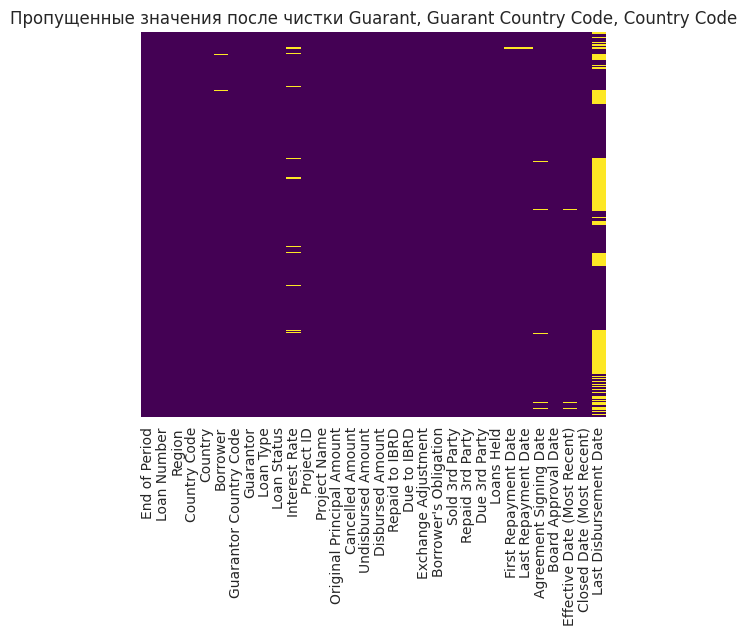

In [25]:
heatmap_builder(data.isnull(),figsize=(6, 5), title="Пропущенные значения после чистки Guarant, Guarant Country Code, Country Code", save_path="../../output/graphics/heatmaps/NaN_values_heatmap_after_first_cleaning.png", xticklabels=data.columns)

### Очистка данных от пропущенных значений в столбце "Borrower"

In [26]:
data["Borrower"].isna().sum()

8723

Borrower - представитель заемщика, который берет займ. Это могут быть министерства, банки, компании и т.д
По косвенным признакам это значение сложно определить, поэтому остается лишь заполнить пропущенные значения значением "Unknown borrower"

In [27]:
data["Borrower"].fillna("Unknown borrower", inplace=True)

### Очистка данных от пропущенных значений в столбце "Interest Rate"

In [28]:
data["Interest Rate"].isna().sum()

30048

Для начала получим общую информацию о столбце Interest Rate. Также поставим формат вывода: дробные числа с двумя знаками после запятой для удобства чтения.

In [29]:
pd.set_option('display.float_format', '{:.2f}'.format)
data["Interest Rate"].describe()

count   1229783.00
mean          4.42
std           3.37
min           0.00
25%           0.43
50%           5.31
75%           7.25
max          12.00
Name: Interest Rate, dtype: float64

<Axes: xlabel='Interest Rate', ylabel='Count'>

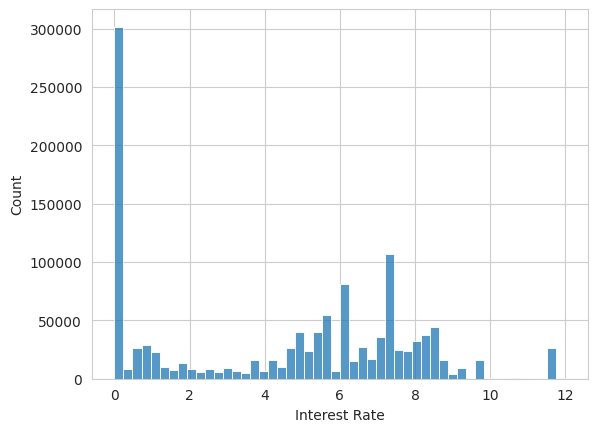

In [30]:
sns.histplot(data["Interest Rate"], bins=50)

In [31]:
data["Interest Rate"].value_counts()

Interest Rate
0.00    299062
7.25     54555
8.50     40435
5.59     34197
7.43     33641
         ...  
4.80         1
3.68         1
3.31         1
4.73         1
5.53         1
Name: count, Length: 596, dtype: int64

Посмотрим на распределение значений в столбце Interest Rate. Заметим, что подавляющее большинство значений равно 0. 
Это связано с что для кредитов, которые могут иметь более одной процентной ставки (например, кредиты с фиксированной ставкой FSL или SCL), процентная ставка отображается как “0”. Таких, оказывается, большинство. 
Таким образом, при заполнении пустых значений в столбце Interest Rate имеет смысл использовать не классическое среднее, а моду.

In [32]:
data["Interest Rate"].mode()

0   0.00
Name: Interest Rate, dtype: float64

In [33]:
data["Interest Rate"].fillna(data["Interest Rate"].mode()[0], inplace=True)

In [34]:
data["Interest Rate"].isna().sum()

0

Оценим на графике, что восстанавливать дальше

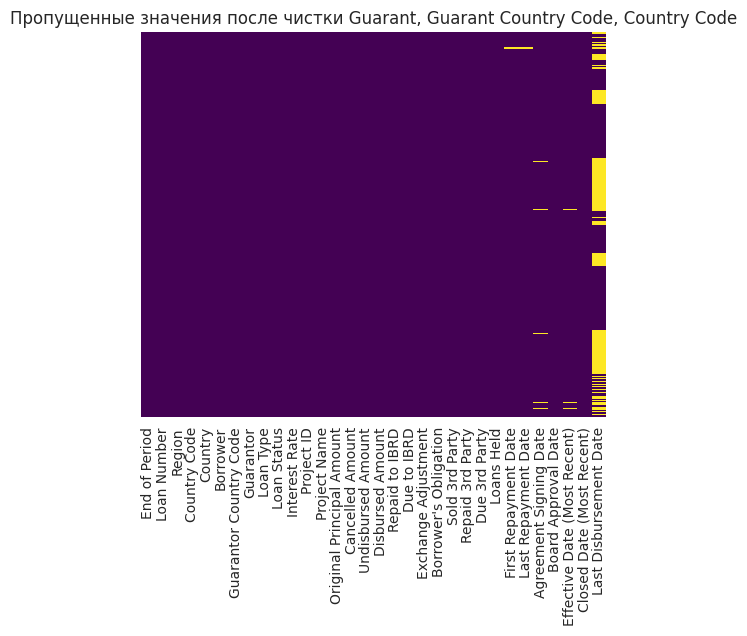

In [35]:
heatmap_builder(data.isnull(),figsize=(6, 5), title="Пропущенные значения после чистки Guarant, Guarant Country Code, Country Code", save_path="../../output/graphics/heatmaps/NaN_values_heatmap_after_first_cleaning.png", xticklabels=data.columns)

### Работа с датами

Изменим формат отображения даты на более удобный для чтения

In [36]:
date_columns = ["Board Approval Date", "Closed Date (Most Recent)", "Effective Date (Most Recent)", "Last Disbursement Date", "Agreement Signing Date", "End of Period", "First Repayment Date", 
                "Last Repayment Date"]

for col in date_columns:
    data[col] = pd.to_datetime(data[col], format="%m/%d/%Y %I:%M:%S %p").dt.strftime("%m/%d/%Y")


Далее есть несколько вариантов восстановления пропущенных дат:
1) Заполнять пропущенные значения при помощи метода ffill, что позволяет заполнять каждое следующее значение предыдущим. Этот метод работает в том случае, если у нас имеются частые и длинные последовательности дат
2) Заполнять пропущенные значения при помощи метода knn, который позволяет заполнять пропущенные значения на основе ближайших соседей. Этот метод эффективен в случае, если у нас имеются небольшие пропуски в данных и данные также объединены в большие группы
3) Просто заполнить филлером, например, "Unknown date". Этот метод не требует дополнительных вычислений, но не позволяет восстановить пропущенные значения.

Я решил воспользоваться третьим методом из-за ограниченности во времени и том, что этот метод не требует дополнительных вычислений.

In [37]:
for col in date_columns:
    data[col].fillna("Unknown date", inplace=True)
data[date_columns].isna().sum()

Board Approval Date             0
Closed Date (Most Recent)       0
Effective Date (Most Recent)    0
Last Disbursement Date          0
Agreement Signing Date          0
End of Period                   0
First Repayment Date            0
Last Repayment Date             0
dtype: int64

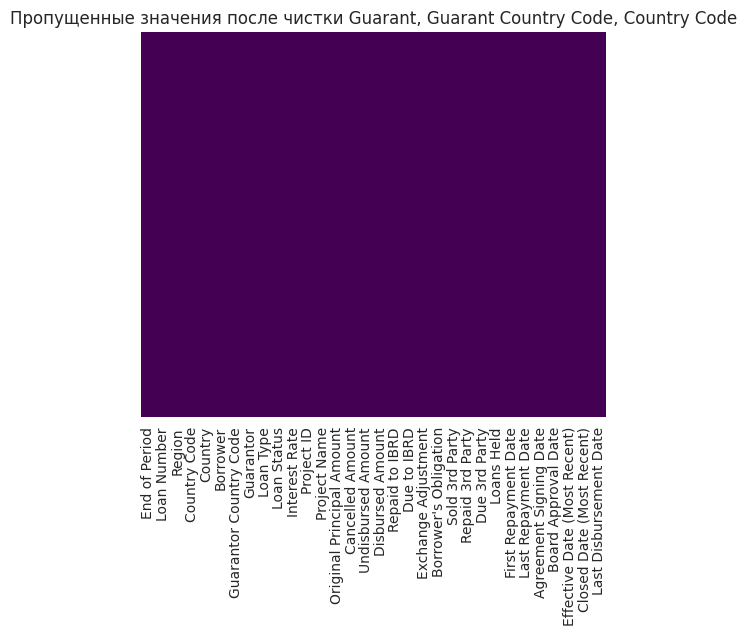

In [38]:
heatmap_builder(data.isnull(),figsize=(6, 5), title="Пропущенные значения после чистки Guarant, Guarant Country Code, Country Code", save_path="../../output/graphics/heatmaps/NaN_values_heatmap_after_first_cleaning.png", xticklabels=data.columns)

Отлично, так или иначе мы заполнили все пробелы и теперь можно приступать к полноценному анализу данных!

###

In [40]:
data.to_csv("../../data/IBRD_Statement_Of_Loans_cleaned.csv", index=False)